 # Automated Image Classification using Advanced Deep Learning Models
 The goal for this Lab is it to provide you understanding of the various deep learning models that we will be using in your project(s). In this Lab we will implement VGG Architecture over CUB200-2011 dataset:

 The CUB200-2011 dataset can be found on its [website](https://paperswithcode.com/dataset/cub-200-2011). We can either use the data zip file or import it using  [Kaggle](https://www.kaggle.com) and [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`. I would prefer all of you do this using Google Colab. This will also help you with Last 3 Labs.

1. Total of 40,000 images are available in the dataset.  
2. Each image is of size 128x128 pixels (64x64).  
3. 10% of the total images (stratified) is our prototype dataset.  
    3.1 4000 images are used for prototyping.  
    3.2 3200 images are used for training and the rest are used for testing (800).  
4. Each image is annotated with a label. --> a classification  
5. Labs will require your own datasets with:  
    5.1 Lab 8 - Vgg16 model pre-trained weights on the 10% dataset.  
    5.2 Lab 9 - Yolo 6 model pre-trained weights on the 10% dataset.  
    5.3 Lab 10 - Inception model pre-trained weights on the 10% dataset.  
    5.4 ResNet 50 model pre-trained weights on the 10% dataset.  
6. Diagnostic plots for each model.  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import PIL
import torchvision
from torchvision import models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tqdm
import cv2
import matplotlib.pyplot as plt
import os
import shutil

ModuleNotFoundError: No module named 'torch'

 ## Data Preprocessing
 ### Downloading and extracting custom datasets
 ### Loading custom datasets
 ### Calculating the mean and std for normalization on custom datasets
 ### Loading transforms to augment and normalize our data

In [ ]:
folder_path = ('677images')

file_path = []
for root, dir, files in os.walk(folder_path):
    for f in files:
        if f=='.DS_Store':
            continue
        file_info = os.path.join(root, f)
        file_path.append(file_info)

lst = [e[10:] for e in file_path]
lst[0:5]

['Green/Light_Green_65.jpg',
 'Green/Light_Green_71.jpg',
 'Green/Light_Green_59.jpg',
 'Green/Light_Green_136.jpg',
 'Green/Light_Green_122.jpg']

In [ ]:
classes = []
for i in lst:
    split = i.split('/')[0]
    classes.append(split)
classes[190:195]

['Green', 'Green', 'Red', 'Red', 'Red']

In [ ]:
df1 = pd.DataFrame(lst,columns=['FNAME'])
df2 = pd.DataFrame(classes, columns=['CLASS'])
df1.insert(0,'ID',range(0,len(df1)))
df2.insert(0,'ID',range(0,len(df2)))
result = pd.merge(df1, df2, on='ID')
result.head(n=5)

,ID,FNAME,CLASS
0,0,Green/Light_Green_65.jpg,Green
1,1,Green/Light_Green_71.jpg,Green
2,2,Green/Light_Green_59.jpg,Green
3,3,Green/Light_Green_136.jpg,Green
4,4,Green/Light_Green_122.jpg,Green


In [ ]:
conditions = [
    (result['CLASS'] == 'Green'),
    (result['CLASS'] == 'Red'),
    (result['CLASS'] == 'Yellow'),
]
choices = [0,1,2]
result['CLASS'] = np.select(conditions, choices)
result.head(n=5)

,ID,FNAME,CLASS
0,0,Green/Light_Green_65.jpg,0
1,1,Green/Light_Green_71.jpg,0
2,2,Green/Light_Green_59.jpg,0
3,3,Green/Light_Green_136.jpg,0
4,4,Green/Light_Green_122.jpg,0


In [ ]:
train_df, test_df = train_test_split(result, test_size=0.2, random_state=677)
train_df['SPLIT'] = 1
test_df['SPLIT'] = 0
train_df.head(n=10)

,ID,FNAME,CLASS,SPLIT
332,332,Red/Light_Red_121.jpg,1,1
480,480,Yellow/Light_Yellow_4.jpg,2,1
55,55,Green/Light_Green_13.jpg,0,1
52,52,Green/Light_Green_154.jpg,0,1
119,119,Green/Light_Green_21.JPG,0,1
24,24,Green/Light_Green_88.jpg,0,1
245,245,Red/Light_Red_163.jpg,1,1
356,356,Red/Light_Red_150.jpg,1,1
323,323,Red/Light_Red_124.jpg,1,1
482,482,Yellow/Light_Yellow_27.jpg,2,1


In [ ]:
train_path = 'TrafficLights/train'
if not os.path.exists(train_path):
    os.makedirs(train_path)

test_path = 'TrafficLights/test'
if not os.path.exists(test_path):
    os.makedirs(test_path)

In [ ]:
for _, row in train_df.iterrows():
    path = '677images/' + row['FNAME']
    label = 'TrafficLights/train/' + row['FNAME'].split('.')[0].split('/')[0]
    if not os.path.exists(label):
        os.makedirs(label)

    target = label +'/'+ row['FNAME'].split('/')[-1]
    shutil.move(path,target)

In [ ]:
for _, row in test_df.iterrows():
    path = '677images/' + row['FNAME']
    label = 'TrafficLights/test/' + row['FNAME'].split('.')[0].split('/')[0]
    if not os.path.exists(label):
        os.makedirs(label)

    target = label +'/'+ row['FNAME'].split('/')[-1]
    shutil.move(path,target)

In [ ]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.4829, 0.4908, 0.4228]
std = [0.2297, 0.2252, 0.2601]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(224),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = 'TrafficLights/train/',
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 64,
    shuffle=True,
    num_workers=0
)

test = torchvision.datasets.ImageFolder(
    root = 'TrafficLights/test/',
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 64,
    shuffle=True,
    num_workers=0
)

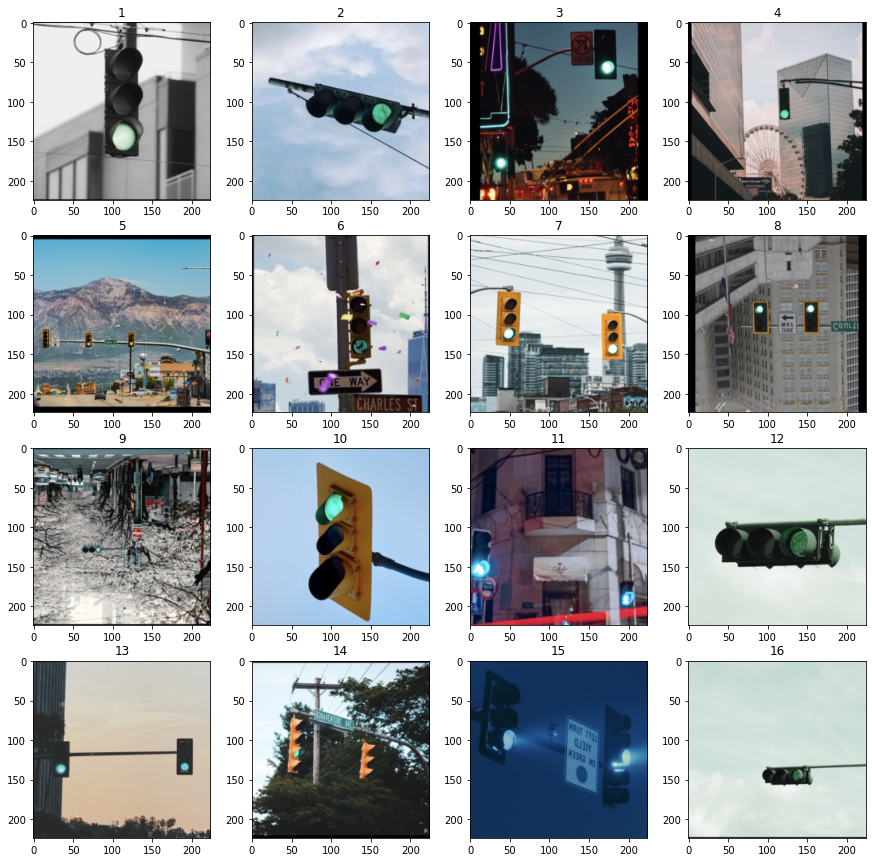

In [ ]:
analysis_path = 'Analysis/'
if not os.path.exists(analysis_path):
  os.makedirs(analysis_path)

fig, axes = plt.subplots(4,4,figsize= (15,15))

for i in range(16):

  img = train[i][0].numpy().transpose(1, 2, 0)
  img = np.clip((std * img) + mean, 0, 1)
  axes.flat[i].imshow(img)
  axes.flat[i].set_title(str(train[i][1]+i+1))

# Follow aspect ratio of either 1:1 or 1.68:1 (8.5, 4.75/5)
fig.savefig('Analysis/train_image_transformations.jpg', dpi=300, bbox_inches='tight')  
fig.savefig('Analysis/train_image_transformations.pdf', dpi=300, bbox_inches='tight')  
plt.show()

 ## Defining a Convolutional Neural Network
 ### Defining the VGG blocks
 ### Defining a CUB200-2011 VGG model

In [ ]:
class CustomVGG(nn.Module):

  def __init__(self, num_classes = 200):
    super().__init__()

    self.features = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5, inplace= False),
      nn.Linear(in_features=25088, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace= False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=4096, out_features=num_classes, bias=True)
    )

  def forward(self, x):

    x = self.features(x)
    x = self.avgpool(x)
    x = x.reshape(x.size(0), -1)
    x = self.classifier(x)

    return x

# if torch.cuda.is_available():
#   cuda = True


VGGscratch = CustomVGG(num_classes=3)


print(VGGscratch)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

In [ ]:
optimizer = optim.SGD(params = VGGscratch.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 5 # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

VGGscratch.train()


pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data,target) in enumerate(train_loader):

    VGGscratch.train()

    # if cuda:
    #   print(torch.cuda.get_device_name(0))
    #   data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()

    out = VGGscratch(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()


    current_loss = loss.cpu().data.item()
    running_loss += current_loss


    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()
          


    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")


  test_running_loss = 0
  VGGscratch.eval()


  with torch.no_grad():


    for batch_idx, (data,target) in enumerate(test_loader):

      # if cuda:
      #   data, target = data.cuda(), target.cuda()

      out = VGGscratch(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()


    LTest = test_running_loss/len(test_loader)


  
  LTrain=running_loss/len(train_loader)
  accu=100.*correct/total
    
  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 5	 Batch Loss: 1.164	  Epoch Loss: 1.021	 Train Acc: 45.855	 Test Loss: 1.030	: 100%|██████████| 5/5 [1:58:14<00:00, 1453.49s/it]  

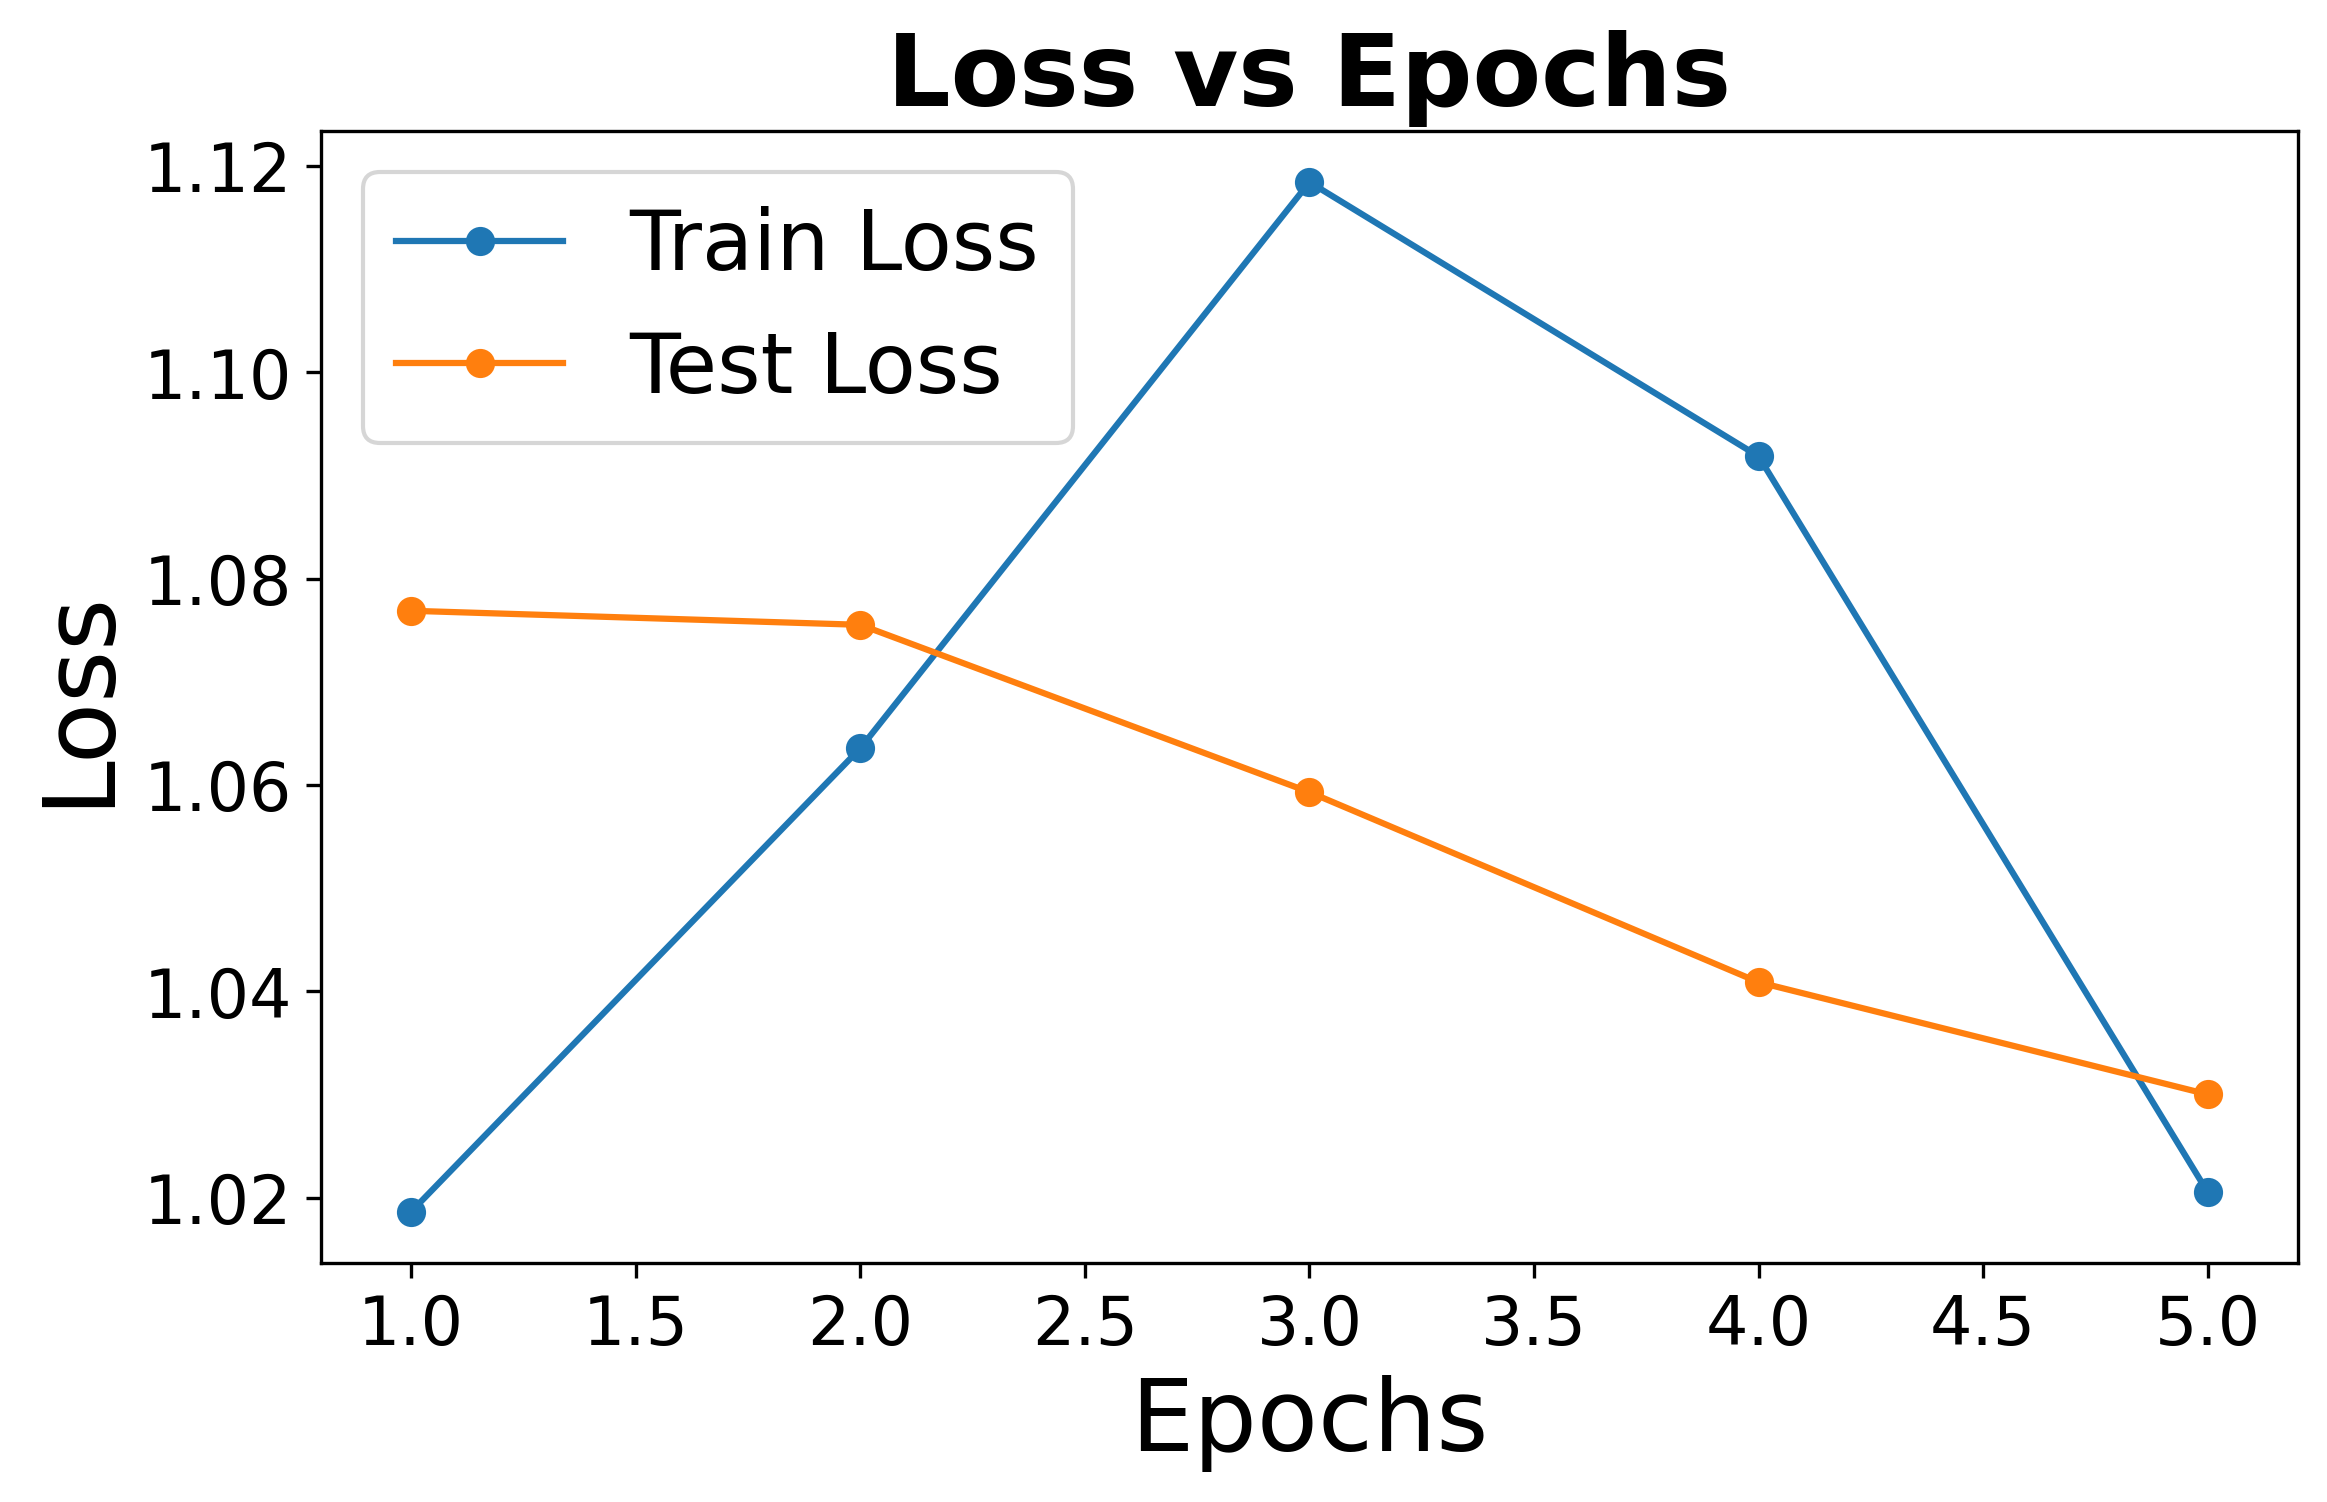

In [ ]:
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("Loss vs Epochs", fontsize = 24, fontweight = 'bold')

plt.savefig("Loss vs Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("Loss vs Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()


In [ ]:
correct = 0
total = 0

VGGscratch.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader): # train_loader
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        
        out = VGGscratch(data)


        for _,i in enumerate(out):

            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1

correct/total

0.4536082474226804

In [ ]:
correct = 0
total = 0

VGGscratch.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        
        out = VGGscratch(data)


        for _,i in enumerate(out):
            
            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1

correct/total

1.0

 ## Training a Convolutional Neural Network
 ### Loading a pre-trained model
 ### Loading pre-trained model parameters into a defined model
 ### Learning rate finder
 ### Discriminative fine-tuning
 ### One cycle learning rate scheduler

In [ ]:
VGGpretrained = torchvision.models.vgg16(pretrained= True)

# for p in list(VGGpretrained.parameters())[:-6]:
#   p.requires_grad = False

VGGpretrained.classifier[6] = nn.Linear(in_features=4096, out_features=200, bias=True)

cuda = torch.cuda.is_available()

if cuda:
 VGGpretrained.cuda()

print(VGGpretrained)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
optimizer = optim.SGD(params = VGGpretrained.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_accuracy = [np.nan]
test_loss = [np.nan]
best_test_acc = -np.inf
best_snapshot_path = None

VGGpretrained.train()


pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data,target) in enumerate(train_loader):

    VGGpretrained.train()

    if cuda:
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()

    out = VGGpretrained(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()


    current_loss = loss.cpu().data.item()
    running_loss += current_loss


    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()
          
    #scheduler.step()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")


  test_total, test_correct, test_running_loss = 0, 0, 0
  VGGpretrained.eval()


  with torch.no_grad():


    for batch_idx, (data,target) in enumerate(test_loader):

      if cuda:
        data, target = data.cuda(), target.cuda()

      out = VGGpretrained(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

      _, predicted = out.max(1)
      test_total += target.size(0)
      test_correct += predicted.eq(target).sum().cpu().item()


    test_accu=100.*test_correct/test_total
    LTest = test_running_loss/len(test_loader)

    if test_accu > best_test_acc:
      best_test_acc = test_accu

      if best_snapshot_path is not None:
        os.remove(best_snapshot_path)
      
      best_snapshot_path = os.path.join(f'VGG_ep={epoch + 1}_acc={best_test_acc:.2f}.pt')
      torch.save(VGGpretrained.state_dict(), best_snapshot_path)

  
  LTrain=running_loss/len(train_loader)
  accu=100.*correct/total
    
  train_accuracy.append(accu)
  test_accuracy.append(test_accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

  pbar.update()

del train_accuracy[0]
del test_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 1	 Batch Loss: 5.423	  Epoch Loss: nan	 Train Acc: nan%	 Test Loss: nan	 Test Acc: nan%	:   0%|          | 0/50 [00:20<?, ?it/s]
EPOCH 50	 Batch Loss: 0.029	  Epoch Loss: 0.066	 Train Acc: 97.930%	 Test Loss: 1.853	 Test Acc: 66.857%	: 100%|██████████| 50/50 [56:26<00:00, 67.76s/it]

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss")
ax.plot(x, test_loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_accuracy)+1)

ax.plot(x, train_accuracy, '-o', label = "Train Accuracy")
ax.plot(x, test_accuracy, '-o', label = "Test Accuracy")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)

plt.show()

In [ ]:
VGGpretrained.load_state_dict(torch.load(best_snapshot_path))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

VGGpretrained.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = VGGpretrained(data)


        for _,i in enumerate(out):

            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1

correct/total

0.6677029360967185

In [ ]:
correct = 0
total = 0

VGGpretrained.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = VGGpretrained(data)


        for _,i in enumerate(out):
            
            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1

correct/total

0.8811744386873921

 ## Evaluating a Convolutional Neural Network
 ### Fine-tuning a pre-trained model to achieve ~80% top-1 accuracy and ~95% top-5 accuracy on a dataset with 200 classes and only 60 examples per class
 ### Viewing our model's mistakes
 ### Visualizing our data in lower dimensions with PCA and t-SNE
 ### Viewing the learned weights of our model

In [ ]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.4829, 0.4908, 0.4228]
std = [0.2297, 0.2252, 0.2601]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(448),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = 'CUB_200_2011/train/',
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 32,
    shuffle=True,
    num_workers=4
)

test = torchvision.datasets.ImageFolder(
    root = 'CUB_200_2011/test/',
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 32,
    shuffle=True,
    num_workers=4
)

In [ ]:
class VGGalter(nn.Module):

  def __init__(self):
    super().__init__()

    self.VGG =  torchvision.models.vgg16(pretrained= True)
    self.VGG.features[30] = nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)

    self.FC4 = nn.Sequential(
        nn.ReLU(inplace = True),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features=1000, out_features=200, bias=True)
    )


  def forward(self, x):

    x = self.VGG.features(x)
    x = self.VGG.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.VGG.classifier(x)
    
    x = self.FC4(x)

    return x


ComplexVGG = VGGalter()


cuda = torch.cuda.is_available()


if cuda:
 ComplexVGG.cuda()

print(ComplexVGG)

VGGalter(
  (VGG): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [ ]:
optimizer = optim.SGD(params = ComplexVGG.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_accuracy = [np.nan]
test_loss = [np.nan]
best_test_acc = -np.inf
best_snapshot_path = None

ComplexVGG.train()


pbar = tqdm.tqdm(total = EPOCHS, position= 0, leave = True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data,target) in enumerate(train_loader):

    ComplexVGG.train()

    if cuda:
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()

    out = ComplexVGG(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()


    current_loss = loss.cpu().data.item()
    running_loss += current_loss


    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()
          
    #scheduler.step()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")


  test_total, test_correct, test_running_loss = 0, 0, 0
  ComplexVGG.eval()


  with torch.no_grad():


    for batch_idx, (data,target) in enumerate(test_loader):

      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ComplexVGG(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

      _, predicted = out.max(1)
      test_total += target.size(0)
      test_correct += predicted.eq(target).sum().cpu().item()


    test_accu=100.*test_correct/test_total
    LTest = test_running_loss/len(test_loader)

    if test_accu > best_test_acc:
      best_test_acc = test_accu

      if best_snapshot_path is not None:
        os.remove(best_snapshot_path)
      
      best_snapshot_path = os.path.join(f'VGGCustom_ep={epoch + 1}_acc={best_test_acc:.2f}.pt')
      torch.save(ComplexVGG.state_dict(), best_snapshot_path)

  
  LTrain=running_loss/len(train_loader)
  accu=100.*correct/total
    
  train_accuracy.append(accu)
  test_accuracy.append(test_accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}%\t Test Loss: {test_loss[-1]:.3f}\t Test Acc: {test_accuracy[-1]:.3f}%\t")

  pbar.update()

del train_accuracy[0]
del test_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.234	  Epoch Loss: 0.088	 Train Acc: 97.212%	 Test Loss: 1.518	 Test Acc: 72.539%	: 100%|██████████| 50/50 [3:56:25<00:00, 283.53s/it]

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss")
ax.plot(x, test_loss, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_accuracy)+1)

ax.plot(x, train_accuracy, '-o', label = "Train Accuracy")
ax.plot(x, test_accuracy, '-o', label = "Test Accuracy")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)

plt.show()

In [ ]:
ComplexVGG.load_state_dict(torch.load(best_snapshot_path))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

ComplexVGG.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = ComplexVGG(data)


        for _,i in enumerate(out):

            if torch.argmax(i) == target[_]:
                correct += 1
            total += 1

correct/total

0.7241796200345423

In [ ]:
correct = 0
total = 0

ComplexVGG.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = ComplexVGG(data)


        for _,i in enumerate(out):
            
            if target[_].cpu().item() in torch.argsort(i)[-5:].cpu().numpy():
                correct += 1
            total += 1

correct/total

0.9174438687392056

In [ ]:
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

VGGscratch.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        
        out = VGGscratch(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

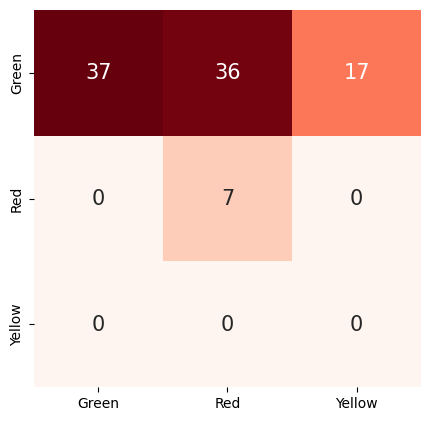

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# conf = confusion_matrix(y_pred= pred, y_true = correct)

# fig,ax = plt.subplots(figsize = (15,15))

# plt.imshow(conf, interpolation='none', cmap = 'YlOrRd_r')


conf = confusion_matrix(pred,correct)


plt.figure(figsize=(5,5),dpi=100)

sns.heatmap(conf,cmap='Reds',cbar=False,annot=True,
            xticklabels=['Green','Red','Yellow'],
            yticklabels=['Green','Red','Yellow'],
            annot_kws={'size':15,'weight':'normal'})
plt.show()

In [ ]:
# !jupyter nbconvert --execute --to html 'Lab08-VGG_image_classification.ipynb'
!jupyter nbconvert --to html 'Lab08-VGG_image_classification.ipynb'

[NbConvertApp] Converting notebook Lab08-VGG_image_classification.ipynb to html
[NbConvertApp] Writing 2007027 bytes to Lab08-VGG_image_classification.html
